In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
import torchvision.models as models
from PIL import Image
import timeit

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
########################

#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### YOUR CODE ENDS HERE ####


In [3]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
print(list(resnet.children())[:-1])

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Prepare the dataset for Siamese Network

In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

T = transforms.ToTensor()
data, data_labels = [],[]
H, W = 360, 540
for file in os.listdir('./PCIA_Resolved_imgs'):
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = Image.open('./PCIA_Resolved_imgs/'+file)
    #print(image.shape)
    #print(file)
    if(image.size[1]) < H:
      continue
    img_new = image.resize((W,H))
    data.append((T(img_new))[:3,:,:])
    data_labels.append(0)

print(len(data))


101


In [7]:
print(len(data))

217


In [6]:
active_count = 0
for file in sorted(os.listdir('./PCIA_Active_imgs')):
  if active_count > 115:
    break
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    #print(file)
    image = Image.open('./PCIA_Active_imgs/'+file)
    if image.size[1] < H:
      continue
    img_new = image.resize((W,H))
    data.append((T(img_new))[:3,:,:])
    data_labels.append(1)
    active_count += 1

In [13]:
active_count

116

In [14]:
data[0].shape


torch.Size([3, 360, 540])

In [8]:
data_labels = torch.from_numpy(np.array(data_labels))

In [16]:
data_labels.shape

torch.Size([217])

In [9]:
from sklearn.utils import shuffle
np.random.seed(0)
# data, data_labels = np.array(data), np.array(data_labels)
N = len(data)
# Train - 80% (15% of which is used as validation data)
# Test - 20%
s_data, s_data_labels = shuffle(data, data_labels, random_state = 9)

In [11]:
x_train, y_train = s_data[:(N*80)//100], s_data_labels[:(N*80)//100]
x_test, y_test = s_data[(N*80)//100:], s_data_labels[(N*80)//100:]

In [12]:
x_train[0].shape

torch.Size([3, 360, 540])

In [13]:
class SiameseDataset(Dataset):
    def __init__(self, data_arr, target_arr, train=True):
        
        self.train = train
        #### YOUR CODE STARTS HERE ####
        # Define a set of transforms for preparing the dataset
        # convert the image to a pytorch tensor
        # normalise the images with mean and std of the dataset
        #self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307), (0.3081))])
        # self.preprocess =  transforms.Compose([transforms.ToTensor()])
        #self.dataset = (self.preprocess(data_arr), target_arr)
        
        # Load the MNIST training, test datasets using `torchvision.datasets.MNIST
        # Set the train parameter to self.train and transform parameter to self.transform
        #self.dataset = datasets.MNIST(root='./', train=self.train, download=True, transform=self.transform)

        #### YOUR CODE ENDS HERE ####
        if self.train:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of training data 
            self.train_data = data_arr
            # assign labels of training data 
            self.train_labels = target_arr
            # get the set of all the labels in the dataset
            self.labels_all = set(self.train_labels.numpy())
            # assign a unique index to all labels in the dataset and store them in a dictionary 
            self.label_to_idx = {lbl : np.where(self.train_labels.numpy()  == lbl)[0]
                                 for lbl in self.labels_all} 

            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of test data 
            self.test_data = data_arr
            # assign labels of test data 
            self.test_labels = target_arr
            # get the set of all the labels in the dataset
            self.labels_all = set(self.test_labels.numpy())
            # assign a unique index to all labels in the dataset and store them in a dictionary 
            self.label_to_idx = {lbl : np.where(self.test_labels.numpy()  == lbl)[0]
                                 for lbl in self.labels_all}  

            #### YOUR CODE ENDS HERE ####
            # DONOT change this line of code  
            random_state = np.random.RandomState(0)

            positive_samples = [] # this will be a list of lists
            for ind in range(0, len(self.test_data), 2):
              positive_samples.append([ind, random_state.choice(self.label_to_idx[self.test_labels[ind].item()]), 1])
            
            negative_samples = []
            for ind in range(1, len(self.test_data), 2):
              negative_samples.append([ind, random_state.choice(self.label_to_idx[np.random.choice(
                                                           list(self.labels_all - set([self.test_labels[ind].item()])))]), 0])
            
            # combine both positive and negative samples into a single variable
            #### YOUR CODE STARTS HERE ####
            self.test_samples = positive_samples + negative_samples
            #### YOUR CODE ENDS HERE ####
    def __len__(self):
        return len(self.train_data) if self.train else len(self.test_data)

    def __getitem__(self, index):
        # get image pair, and the associated label (1 for similar, 0 for dissimilar)
        if self.train:
            #### YOUR CODE STARTS HERE ####
            # choose if training sample is similar or dissimilar
            target = np.random.choice(2) ##Randomly choose '0'(dissimilar) or '1'(similar)
            # choose two images call them `first_image` and `second_image`
            first_image, lbl_1 = self.train_data[index], self.train_labels[index].item()
            ##--Choose image similar to first_image--## 
            if target == 1:
                similar_idx = index
                #chose a similar img other than first_image.
                while similar_idx == index:
                    similar_idx = np.random.choice(self.label_to_idx[lbl_1])
                second_image = self.train_data[similar_idx]
            ##--Choose image dissimilar to first_image--##
            else:
                diff_label = np.random.choice(list(self.labels_all - set([lbl_1])))
                diff_index = np.random.choice(self.label_to_idx[diff_label])
                second_image = self.train_data[diff_index]
           
            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # select two images from self.test_samples, call them `first_image` and `second_image`
            first_image = self.test_data[self.test_samples[index][0]]
            second_image = self.test_data[self.test_samples[index][1]]
            target = self.test_samples[index][2]
            #### YOUR CODE ENDS HERE ####
        
        # first_image = Image.fromarray(first_image.numpy(), mode='L')
        # second_image = Image.fromarray(second_image.numpy(), mode='L')
        # first_image = self.transform(first_image)
        # second_image = self.transform(second_image)
        return (first_image, second_image), target


In [20]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # Define a sequential block as per the instructions below:
        # Build three blocks with each block containing: Conv->PReLU->Maxpool layers
        # Three conv layers should have 16, 32, 64 output channels respectively
        # Use convolution kernel size 3
        # For maxpool use a kernel size of 2 and stride of 2
        resnet = models.resnet18(pretrained =True) 
        # remove the last FC layer in the network
        modules = list(resnet.children())[:-1] #selecting all but last block
        #define a sequential model with the modules obtained above
        self.convnet = nn.Sequential(*modules)
        # self.convnet = nn.Sequential(nn.BatchNorm2d(3),
        #                              nn.Conv2d(3, 16, 3), nn.PReLU(),nn.MaxPool2d(2, stride=2),
        #                              nn.Conv2d(16, 32, 3), nn.PReLU(),nn.MaxPool2d(2, stride=2),
        #                              nn.Conv2d(32, 64, 3), nn.PReLU(),nn.MaxPool2d(2, stride=2))
                                    
        # Define linear->PReLU->linear->PReLU->linear
        # The first two linear layers should have 256 and 128 output nodes
        # The final FC layer should have 2 nodes

        self.fc = nn.Sequential(nn.Linear(512, 512),nn.PReLU(),
                                nn.Dropout(p=0.4))
                                
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
      #### YOUR CODE STARTS HERE ####
        # Define the forward pass, convnet -> fc
        output = self.convnet(x)
        output = output.view(output.size()[0],-1)
        output = self.fc(output)
        #### YOUR CODE ENDS HERE ####
        return output

In [16]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        # Call the embedding network for both the inputs and return the output
        #### YOUR CODE ENDS HERE ####
        op1 = self.embedding_net(x1)
        op2 = self.embedding_net(x2)
        #### YOUR CODE ENDS HERE ####
        return op1, op2

Pairwise contrastive loss
$$
L\left(x_{0}, x_{1}, y\right)=\frac{1}{2} y\left\|f\left(x_{0}\right)-f\left(x_{1}\right)\right\|_{2}^{2}+\frac{1}{2}(1-y)\left\{\max (0, m-\sqrt{\|f(x_{0})-f(x_{1})\|_{2}^{2} + \epsilon)})\right\}^{2}
$$

In [17]:
class ContrastiveLossSiamese(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLossSiamese, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target):
        # Use the equation mentioned above to define the loss
        #### YOUR CODE STARTS HERE ####
        L2_dist = (output1-output2).pow(2).sum(1)
        loss_value = (target*(L2_dist) + (1-target)*F.relu(self.margin-(L2_dist + self.eps).sqrt()).pow(2))/2
        #### YOUR CODE ENDS HERE ####
        loss_value = loss_value.mean()

        return loss_value

In [18]:
def train(model, train_loader, device, optimizer, criterion, epoch):
    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        # data is not a single value here,
        # ensure datatype of variable `data` is tuple
        
        if type(data) not in (tuple, list):
            data = (data,)
        data = tuple(d.to(device) for d in data)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named outputs
        # python star operator will be useful here
        # if the datatype of outputs is not a tuple, make it to a tuple
        outputs = model(*data)
        if type(outputs) is not tuple:
            outputs = (outputs,)

        # create inputs to the contrastive loss (datatype should be tuple)
        # calculate the loss using criterion 
        lossfunc_inp = (*outputs, target)
        loss = criterion(*lossfunc_inp)
        # append the loss to losses list and update the total_loss variable
        losses.append(loss.item())
        total_loss += loss.item()
        # do a backward pass
        loss.backward()
        
        # update the weights
        optimizer.step()
        #### YOUR CODE ENDS HERE ####

        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))  
    total_loss /= (batch_idx + 1)
    print('Average loss on training set: {:.6f}'.format(total_loss))
    return total_loss ##for plotting

def test(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
          target = target if len(target) > 0 else None
          #### YOUR CODE STARTS HERE ####
          # send the image, target to the device
          # data is not a single value here,
          # ensure datatype of variable `data` is tuple
          if type(data) not in (tuple, list):
              data = (data,)
            
          data = tuple(d.to(device) for d in data)
          target = target.to(device)
          # pass the image to the model and assign the output to variable named outputs
          # python star operator will be useful here
          # if the datatype of outputs is not a tuple, make it to a tuple
          outputs = model(*data)
          if type(outputs) is not (tuple):
              outputs = (outputs,)
          # create inputs to the contrastive loss
          # datatype of target should be tuple
          # calculate the loss
          lossfunc_inp = (*outputs, target)
          loss = criterion(*lossfunc_inp)
          # update the test_loss variable
          test_loss += loss
          #### YOUR CODE ENDS HERE ####

    test_loss /= len(test_loader)
    print('Average loss on test set: {:.6f}'.format(test_loss))
    return test_loss ##for plotting


In [21]:
# define the training and test sets
# use SiameseDataset
#dataset = None
train_dataset = SiameseDataset(x_train, y_train)
test_dataset = SiameseDataset(x_test, y_test,train = False)

# create dataloaders for training and test datasets
# use a batch size of 128 and set shuffle=True for the training set, set num_workers to 2 and pin_memory to True
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True, num_workers=2, 
                                               pin_memory = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=False, num_workers=2,
                                              pin_memory = True)

margin = 1.
# create a instance of the embedding network and pass it as input to Siamese network
embedding_net = EmbeddingNet()
model = SiameseNetwork(embedding_net)
model.to(device)
# define the contrative loss with the specified margin
criterion = ContrastiveLossSiamese(margin)
optimizer = optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [23]:
start = timeit.default_timer()
loss_vals_train = []
loss_vals_test = []
for epoch in range(1, 21):
  loss1 = train(model, train_dataloader, device, optimizer, criterion, epoch)
  loss2 = test(model, test_dataloader, device, criterion)
  loss_vals_train.append(loss1)
  loss_vals_test.append(loss2)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/173 (0%)]	Loss: 1.520132
Average loss on training set: 1.617367
Average loss on test set: 0.174186
Train Epoch: 2 [0/173 (0%)]	Loss: 1.338983
Average loss on training set: 1.359860
Average loss on test set: 0.161442
Train Epoch: 3 [0/173 (0%)]	Loss: 1.330865
Average loss on training set: 1.115650
Average loss on test set: 0.170313
Train Epoch: 4 [0/173 (0%)]	Loss: 1.026205
Average loss on training set: 0.953320
Average loss on test set: 0.141823
Train Epoch: 5 [0/173 (0%)]	Loss: 0.820296
Average loss on training set: 0.737398
Average loss on test set: 0.170981
Train Epoch: 6 [0/173 (0%)]	Loss: 0.705905
Average loss on training set: 0.632302
Average loss on test set: 0.183975
Train Epoch: 7 [0/173 (0%)]	Loss: 0.516870
Average loss on training set: 0.494073
Average loss on test set: 0.186841
Train Epoch: 8 [0/173 (0%)]	Loss: 0.451338
Average loss on training set: 0.423698
Average loss on test set: 0.191663
Train Epoch: 9 [0/173 (0%)]	Loss: 0.356914
Average loss on train

### Question 4

Run the code cell above and plot(on the same graph) the average train and test losses w.r.t epochs trained.

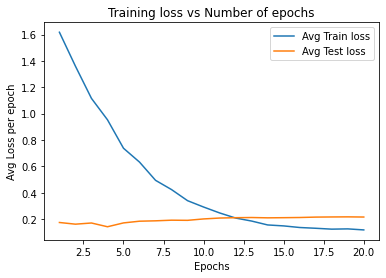

In [26]:
##--PLOTTING--##
import matplotlib.pyplot as plt
plt.plot(np.linspace(1, 20, 20).astype(int), loss_vals_train, label = 'Avg Train loss')
plt.plot(np.linspace(1, 20, 20).astype(int), loss_vals_test, label = 'Avg Test loss')
plt.title("Training loss vs Number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Avg Loss per epoch")
plt.legend()
plt.show()

In [31]:
cuda = torch.cuda.is_available()

import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1']#, '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e']#, '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(2):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 512))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            # if cuda:
            #     images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [32]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_dataloader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_dataloader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

AttributeError: ignored

### Question 5

We have looked at training a Siamese Network with a pairwise contrastive loss. How would you modify the architecture above to use a triplet loss? The triplet loss is a ranking loss that uses image triplets consisting of an anchor $x_a$, a positive sample(similar to the anchor image) $x_p$ and a negative sample(dissimilar to the anchor image) $x_n$. Given triplet $(x_a, x_p, x_n)$ the teiplet loss is:

$$
L\left(x_{a}, x_{p}, x_{n}\right)=\max \left(0, m + \|f(x_{a})-f(x_{p})\|_{2}^{2} - \|f(x_{a})-f(x_{n})\|_{2}^{2}\right)
$$

1. Write the dataloader to get triplets.
2. Write code for class TripletLossSiamese. (the triplet loss)
3. Describe in words how would you modify the network architecture to train it with a triplet loss.

In [ ]:
# Question 2.1, dataloader for triplets
class TripletDataset(Dataset):
    def __init__(self, train=True):
        
        self.train = train
        #### YOUR CODE STARTS HERE ####
        # Define a set of transforms for preparing the dataset
        # convert the image to a pytorch tensor
        # normalise the images with mean and std of the dataset
        self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307), (0.3081))])
        
        # Load the MNIST training, test datasets using `torchvision.datasets.MNIST
        # Set the train parameter to self.train and transform parameter to self.transform
        self.dataset = datasets.MNIST(root='./', train=self.train, download=True, transform=self.transform)

        #### YOUR CODE ENDS HERE ####
        if self.train:
            #### YOUR CODE STARTS HERE ####
            # assign input (x-values) of training data 
            self.train_data = self.dataset.data
            # assign labels of training data 
            self.train_labels = self.dataset.targets
            # get the set of all the labels in the dataset
            self.labels_all = set(self.train_labels.numpy())
            # assign a unique index to all labels in the dataset and store them in a dictionary 
            self.label_to_idx = {lbl : np.where(self.train_labels.numpy()  == lbl)[0]
                                 for lbl in self.labels_all} 
                                 
            #### YOUR CODE ENDS HERE ####
            # assign input (x-values) of test data 
            self.test_data = self.dataset.data
            # assign labels of test data 
            self.test_labels = self.dataset.targets
            # get the set of all the labels in the dataset
            self.labels_all = set(self.test_labels.numpy())
            # assign a unique index to all labels in the dataset and store them in a dictionary 
            self.label_to_idx = {lbl : np.where(self.test_labels.numpy()  == lbl)[0]
                                 for lbl in self.labels_all}  

            #### YOUR CODE ENDS HERE ####
            # DONOT change this line of code  
            random_state = np.random.RandomState(0)

            triplets = [] #this will be list of lists
            for i in range(len(self.test_data)):
                triplets.append([i, random_state.choice(self.label_to_idx[self.test_labels[i].item()]),
                 random_state.choice(self.label_to_idx[np.random.choice(list(self.labels_all - set([self.test_labels[i].item()])))])
                                ])
            self.test_samples = triplets

           
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # get image triplet
        if self.train:
            anchor, anchor_label = self.train_data[index], self.train_labels[index].item
            #### YOUR CODE STARTS HERE ####
            #choose positive and negative image call them `positive` and `negative` respectively
            pos_idx = index
            #chose a positive img other than first_image.
            while pos_idx == index:
                pos_idx = np.random.choice(self.label_to_indices[anchor_label])
            neg_lbl = np.random.choice(list(self.labels_set - set([anchor_label])))
            neg_idx = np.random.choice(self.label_to_indices[neg_lbl])
            positive = self.train_data[pos_idx]
            negative = self.train_data[neg_idx]
            #### YOUR CODE ENDS HERE ####
        else:
            #### YOUR CODE STARTS HERE ####
            # select three images from self.test_samples
            anchor = self.test_data[self.test_samples[index][0]]
            positive = self.test_data[self.test_samples[index][1]]
            negative = self.test_data[self.test_samples[index][2]]
            #### YOUR CODE ENDS HERE ####
        
        anchor = Image.fromarray(anchor.numpy(), mode='L')
        positive = Image.fromarray(positive.numpy(), mode='L')
        negative = Image.fromarray(negative.numpy(), mode='L')
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)
        return (anchor, positive, negative), []

In [ ]:
# Question 2.2, define triplet loss
class TripletLossSiamese(nn.Module):

    def __init__(self, margin):
        super(TripletLossSiamese, self).__init__()
        self.margin = margin

    def forward(self, output_anchor, output_positive, output_negative):
        # Use the triplet loss equation mentioned above to define the loss
        #### YOUR CODE STARTS HERE ####
        L2_pos = (output_anchor - output_positive).pow(2).sum(1)  
        L2_neg = (output_anchor - output_negative).pow(2).sum(1)  
        loss_value = F.relu(self.margin+L2_pos-L2_neg)
        #### YOUR CODE ENDS HERE ####
        loss_value = loss_value.mean()

        return loss_value